# **Chap 6：计算机视觉**

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from source.code import ch6
from source.code import utils

2023-05-14 23:19:47.946758: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 23:19:48.104100: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-14 23:19:48.135944: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-14 23:19:48.804302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=1)

## **6.1 目标检测**

### **6.1.1 目标检测和边界框**

在 CNN 的章节中，我们介绍了如何搭建一个卷积神经网络处理**图像分类任务**
* 在图像分类任务中，我们假设**图像中只有一个主要物体对象**，我们**只关注如何识别其类别**
* 但很多时候**图像里有多个我们感兴趣的目标**，我们不仅想知道它们的**类别**，还想得到**它们在图像中的具体位置**

在**计算机视觉**（**Computer Vision**，简称**CV**）领域，我们称这类任务为**目标检测**（**Object Detection**），它是无人驾驶，智能机器人等实际应用场景中的核心任务

下面我们将基于一张狼和羊的图像进行演示

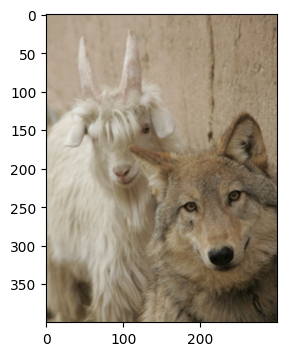

In [3]:
img = plt.imread("./source/Chap6/wolf_sheep.png")
fig = plt.figure(figsize=(3, 4))
plt.imshow(img)

在目标检测中，我们通常使用**边界框**（**boudning box**）来描述对象的空间位置，**边界框是矩形**
* 矩形由**左上角的以及右下角的** $(x,y)$ **坐标**决定，即**对角表示**
* 另一种边界框的表示方法是**以边界框中心** $(x,y)$ 为坐标，然后通过**高度和宽度**确定边界框
* 这**两种表示方法可以进行相互转换**

In [4]:
# 边界框的对角表示转换为中心表示
def box_corner_to_center(boxes : tf.Tensor):
    # boxes 形状: （N, 4)，N是边界框的数量
    # 取出边界框的对角坐标，分别左上和右下
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    # 计算边界框的中心坐标
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    # 计算边界框的宽度和高度
    w = x2 - x1
    h = y2 - y1
    # 重新组合边界框的坐标
    boxes = tf.stack([cx, cy, w, h], axis=-1)
    return boxes

In [5]:
# 边界框的中心表示转换为对角表示
def box_center_to_corner(boxes : tf.Tensor):
    # boxes 形状: （N, 4)，N是边界框的数量
    # 取出边界框的中心坐标和宽度高度
    cx, cy, w, h = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    # 计算边界框的左上和右下坐标
    x1 = cx - w / 2
    y1 = cy - h / 2
    x2 = cx + w / 2
    y2 = cy + h / 2
    # 重新组合边界框的坐标
    boxes = tf.stack([x1, y1, x2, y2], axis=-1)
    return boxes

函数 `box_corner_to_center` 和 `box_center_to_corner` 已经写入 `./source/code/ch6.py`，我们将**根据坐标信息定义图像中狼和羊的边界框**，图像中**坐标的原点是图像的左上角**，向右是 $x$ 轴正方向，向下是 $y$ 轴正方向

In [7]:
# 采用对角表示的边界框
wolf_box = [110.0, 170.0, 290.0, 380.0]
sheep_box = [10.0, 30.0, 150.0, 350.0]
# 拼接成一个张量
boxes = tf.constant([wolf_box, sheep_box])

验证一下我们的转换函数

In [8]:
box_center_to_corner(box_corner_to_center(boxes)) == boxes

<tf.Tensor: shape=(2, 4), dtype=bool, numpy=
array([[ True,  True,  True,  True],
       [ True,  True,  True,  True]])>

函数 `bbox_to_rect` 用于**将边界框坐标转换为图像中的矩阵**，`bbox` 是 Bounding Box 的缩写

In [9]:
def bbox_to_rect(box, color):
    from matplotlib.patches import Rectangle
    # box 是对角表示的边界框
    return Rectangle(xy=(box[0], box[1]), width=box[2]-box[0], height=box[3]-box[1],
                     fill=False, edgecolor=color, linewidth=2)

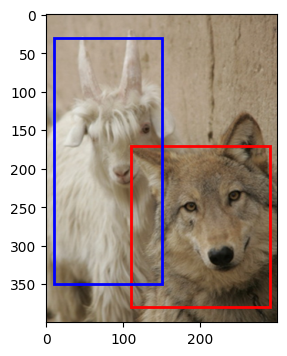

In [10]:
fig = plt.figure(figsize=(3, 4))
plt.imshow(img)
fig.axes[0].add_patch(bbox_to_rect(wolf_box, 'red'))
fig.axes[0].add_patch(bbox_to_rect(sheep_box, 'blue'))

### **6.1.2 锚框**

目标检测算法**通常需要在输入图像中采集大量的区域**，然后**判断这些区域中是否包含我们感兴趣的目标**，并**调整区域边界**从而更**准确地预测目标的真实边界框**（**Ground-Truth Bounding Box**）

不同的模型使用的区域采样方法可能不同，我们介绍其中最简单和常用的方法：**以每个像素为中心，生成多个缩放比和宽高比不同的边界框**，这些边界框被称为**锚框**（**Anchor Box**）

**(1) 生成多个锚框**

假设输入图像的大小为 $h\times w$，$h,w$ 分别表示高度和宽度，我们选定一个**缩放比**（`sizes`） $s\in(0,1]$，**宽高比**（`ratios`） $r>0$，那么以每个像素为中心，**锚框的宽度和高度分别为** $hs\sqrt{r}, hs/\sqrt{r}$，当中心像素 $cx,cy$ 给定，已知高宽的锚框就确定了
* 要生成多个不同形状的锚框，我们可以**设置很多缩放比** $s_1,\cdots,s_n$ 和**许多宽高比** $r_1,\cdots,r_m$
* 当使用这些比例的所有组合以每个像素为中心时，**输入图像将总共有** $w\times h\times nm$ **个锚框**
* 尽管这些锚框可能会覆盖所有真实边界框，但**计算复杂度可能过高**（尤其当像素 $h,w$ 很大时），实践中，我们**只考虑包含** $s_1$ **或** $r_1$ **的组合**：
    $$
    (s_1,r_1),(s_1,r_2),\cdots,(s_1,r_m),(s_2,r_1),(s_3,r_1),\cdots,(s_n,r_1)
    $$
    此时**整个图像生成的锚框数量减少到** $w\times h\times (n+m-1)$

为了计算方便，`generate_multi_bbox` 生成的是**相对位置标记的锚框**，每个**像素中心坐标都除以了高宽**，函数已经写入 `./source/code/ch6.py`
* 如果要得到图像中锚框的**绝对位置坐标**，只需要**将输出结果乘以宽高**，后面会演示
* `tf.repeat` 和 `tf.tile` 是**两种不同重复元素的方法**，它们的功能可以查看使用文档

In [11]:
def generate_multi_bbox(img, sizes, ratios):
    """
    ### 生成以每个像素为中心的锚框

    Parameters
    ----------
    img : tf.Tensor
        输入图像，形状为 (N, h, w, C)\n
        N 是图像的数量，C 是通道数，h 和 w 是图像的高和宽
    sizes : list
        锚框缩放比
    ratios : list
        锚框宽高比
    """
    height, width = img.shape[1:3] # 图像的高和宽
    num_sizes, num_ratios = len(sizes), len(ratios) # 锚框缩放比和宽高比的数量
    boxes_per_pixel = num_sizes + num_ratios - 1 # 每个像素的锚框数量
    sizes = tf.constant(sizes, dtype=tf.float32)
    ratios = tf.constant(ratios, dtype=tf.float32)

    # 为了将锚框的中心放在像素的中心，需要设置偏移量 0.5
    # 因为每个像素都是 1x1 的小正方形，偏移 0.5 是小正方形中心
    offset_h, offset_w = 0.5, 0.5
    steps_h, steps_w = 1.0 / height, 1.0 / width # 高度和宽度移动的步长

    # 生成锚框的中心坐标
    # 高度中心，(0.5/height, 1.5/height, ..., (height-0.5)/height)
    center_h = (tf.range(height, dtype=tf.float32) + offset_h) * steps_h
    # 宽度中心，(0.5/width, 1.5/width, ..., (width-0.5)/width)
    center_w = (tf.range(width, dtype=tf.float32) + offset_w) * steps_w
    # 生成网格，shift_y 和 shift_x 形状都是 (height, width)
    # indexij='ij' 表示生成的网格以 center_h 为行，center_w 为列
    shift_y, shift_x = tf.meshgrid(center_h, center_w, indexing='ij') 
    shift_y, shift_x = tf.reshape(shift_y, [-1]), tf.reshape(shift_x, [-1]) # 拉直为向量

    # 生成锚框的高度和宽度
    # 之后就可以和中心坐标一起组合成锚框的对角坐标
    # h = s/sqrt(r), w = s*sqrt(r)
    w = tf.concat((sizes * tf.sqrt(ratios[0]), sizes[0] * tf.sqrt(ratios[1:])), axis=0) * (height / width)
    h = tf.concat((sizes / tf.sqrt(ratios[0]), sizes[0] / tf.sqrt(ratios[1:])), axis=0)
    
    # 第一步 tf.stack 生成 (n + m - 1, 4) = (boxes_per_pixel, 4) 的张量
    # 第二步 tf.tile 先将 anchor_wh 重复为 (boxes_per_pixel*height*width, 4)
    # 最后除以 2，得到半高半宽
    anchor_wh = tf.stack((-w, -h, w, h), axis=1) # 形状：(boxes_per_pixel, 4)
    anchor_wh = tf.tile(anchor_wh, (height*width, 1)) / 2 # 形状：(boxes_per_pixel*height*width, 4)

    # 生成锚框中心
    xy = tf.stack((shift_x, shift_y, shift_x, shift_y), axis=1) # 形状：(height*width, 4)
    # 同样将中心坐标复制 boxes_per_pixel 次，准备与 anchor_wh 运算
    xy = tf.repeat(xy, boxes_per_pixel, axis=0) # 形状：(boxes_per_pixel*height*width, 4)
    
    # 将中心坐标与半高半宽相加，得到锚框的对角坐标
    anchor_box = xy + anchor_wh # 形状：(boxes_per_pixel*height*width, 4)
    return anchor_box

可以使用狼和羊的图片来生成锚框，可以看到锚框的形状是 `(hw(n+m-1), 4)`

In [12]:
img = plt.imread("./source/Chap6/wolf_sheep.png")
h, w = img.shape[:2]
print("图像高宽：{}x{}".format(h, w))

# 生成四维张量 X，形状为 (batch_size, h, w, num_channels)
X = tf.zeros((1, h, w, 3))
anchor_boxes = ch6.generate_multi_bbox(X, sizes=[0.5, 0.25, 0.10], ratios=[1, 2, 0.5])
anchor_boxes.shape

图像高宽：400x300


TensorShape([600000, 4])

如果将锚框的形状更改为 `(h, w, m+n-1, 4)`，则可以获得以指定像素 $(i,j)$ 位置为中心的所有锚框
* 这些锚框标注了**左上角和右下角的坐标** $(x_1,y_1,x_2,y_2)$

In [13]:
boxes = tf.reshape(anchor_boxes, (h, w, -1, 4))
# 以 (150, 150) 为中心的 5 个锚框
boxes[150, 150, :, :].numpy()

array([[0.16833332, 0.12625   , 0.83500004, 0.62625   ],
       [0.33499998, 0.25125   , 0.66833335, 0.50125   ],
       [0.435     , 0.32625   , 0.5683333 , 0.42625   ],
       [0.03026214, 0.1994733 , 0.9730712 , 0.5530267 ],
       [0.2659644 , 0.02269661, 0.73736894, 0.7298034 ]], dtype=float32)

下面的函数 `show_bboxes` 帮助我们**绘制边界框和锚框**，并能为这些边界框添加标签，函数已写入 `./source/code/ch6.py`

In [14]:
# 绘制锚框和边界框
def show_bboxes(axes, bboxes, labels=None, colors=None):
    # 将变量转换成列表
    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, default_values=['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = ch6.bbox_to_rect(bbox.numpy(), color)
        axes.add_patch(rect) # 添加边界框
        if labels is not None and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w' # 如果锚框是白色，则文字用黑色
            # 在边界框的左上角创建一个文本框来标注标签
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center', ha='center', 
                      fontsize=9, color=text_color, bbox=dict(facecolor=color, lw=0))

绘制锚框之前，我们需要先对生成的锚框坐标进行放缩
* 我们生成的锚框坐标是**相对坐标**，乘以图像的高宽可以恢复到**绝对坐标**

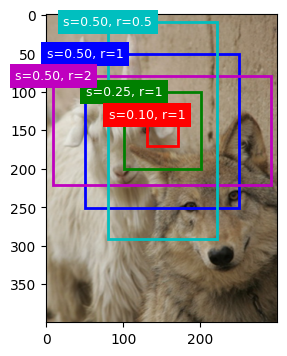

In [15]:
bbox_scale = tf.constant((w, h, w, h),dtype=tf.float32)
fig = plt.figure(figsize=(3, 4))
plt.imshow(img)
ch6.show_bboxes(fig.axes[0], boxes[150, 150, :, :] * bbox_scale, 
            labels=['s=0.50, r=1', 's=0.25, r=1', 's=0.10, r=1', 's=0.50, r=2','s=0.50, r=0.5'])

**(2) 交并比 IoU**

锚框是我们通过采样在图像中标注的图像区域，**如何度量锚框质量呢？**，如果已知目标的真实边界框，我们可以衡量锚框和真实边界框之间的**相似性**，**Jaccard 系数**可以衡量这两个矩形之间的相似程度，给定集合 $A,B$，**Jaccard 系数定义为集合交易比上并集的大小**：

$$
J(A,B) = \frac{ |A\cap B| }{|A\cup B|}
$$

我们可以**将任何边界框的像素区域视为一个集合**。通过这种方式，可以**将像素集的 Jaccard 系数来测量两个边界框的相似性**，对于两个边界框，它们的 Jaccrad 系数通常称为**交并比**（**Intersection over Union**，**IoU**），IoU **取值范围为** $[0,1]$

<img src="./source/Chap6/IoU.svg" width=300>

In [16]:
def box_IoU(boxes1, boxes2):
    # 计算两个锚框或边界框列表中成对的 IoU
    # boxes1, boxes2 形状：(boxes1 数量, 4) 和 (boxes2 数量, 4)

    # 计算 box 面积：(x2 - x1) * (y2 - y1)
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]))
    # 计算两个 box 的面积
    area1 = box_area(boxes1) # 形状：(boxes1 数量, )
    area2 = box_area(boxes2) # 形状：(boxes2 数量, )

    # 下面使用了广播机制，通过[:, None] 在中间添加了一个维度
    # 交集左上角坐标，形状：(boxes1 数量, boxes2 数量, 2)
    inter_upperleft = tf.maximum(boxes1[:, None, :2], boxes2[:, :2]) 
    # 交集右下角坐标，形状：(boxes1 数量, boxes2 数量, 2)
    inter_lowerright = tf.minimum(boxes1[:, None, 2:], boxes2[:, 2:])

    # 先计算交集的高和宽，如果高或宽出现负数，说明相交的面积为 0
    inters = tf.maximum(inter_lowerright - inter_upperleft, 0.0)
    # 交集面积，形状：(boxes1 数量, boxes2 数量)
    inter_area = inters[:, :, 0] * inters[:, :, 1]
    # 并集面积，形状：(boxes1 数量, boxes2 数量)
    # 这里用了 A\cup B = A + B - A\cap B
    union_area = area1[:, None] + area2 - inter_area

    return inter_area / union_area # IoU，形状：(boxes1 数量, boxes2 数量)

**(3) 在训练数据中标注锚框**

在目标检测的训练集中，我们**将每个锚框视为一个训练样本**：
* 为了训练模型，我们需要每个锚框的**类别**（`class`）和**偏移量**（`offset`）
* `class` 是与锚框相关的**对象的类别**，`offset` 是**真实边界框相对于锚框的偏移**
* 在**预测**时，我们为图像生成多个锚框，预测所有锚框的 `class` 和 `offset`，根据预测的 `offset` 来**调整锚框的位置以获得预测的边界框**，最后**只输出符合特定条件的边界框和预测类别**

目标检测训练集标签是**带有真实边界框和所包含物体类别的标签**，要**标记我们生成的锚框**，可以参考**将其分配到最接近此锚框的真实边界框**的位置和类别标签

下面介绍一种简单的算法，它用于**实现最接近的真实边界框的分配**

给定图像，假设生成的锚框有 $A_1,A_2,\cdots,A_{n_a}$，真实边界框是 $B_1,B_2,\cdots,B_{n_b}$，其中 $n_a\geq n_b$，定义一个矩阵 $X\in\mathbb{R}^{n_a\times n_b}$，其中第 $(i,j)$ 位置处元素 $x_{ij}$ 表示 $A_i,B_j$ 的 IoU，算法步骤如下：
1. 在矩阵 $X$ 中找到最大元素，并将它的行列索引标记为 $i_1,j_1$，将真实边界框 $B_{j_1}$ 分配给锚框 $A_{i_1}$，这很直观，因为 $x_{i_1 j_1}$ 描述了最接近的一对锚框和边界框，**分配完成后，丢弃矩阵中的** $i_1,j_1$ **行列**
2. 在矩阵 $X$ 中寻找剩余元素中的最大元素，并将它的行列索引标记为 $i_2,j_2$，将真实边界框 $B_{j_2}$ 分配给锚框 $A_{i_2}$，**分配完成后，丢弃矩阵中的** $i_2,j_2$ **行列**
3. 继续重复上述过程，**直到将所有的列丢弃**，此时所有的**真实边界框都分配给了一个对应的锚框**
4. 继续遍历剩下的 $n_a - n_b$ 个锚框，给定任何锚框 $A_i$，在 $X_i$ 中找到与 $A_i$ 的 **IoU 最大的真实边界框** $B_j$，当 IoU **大于给定的阈值时**，将 $B_j$ 分配给 $A_i$，否则，**放弃锚框** $A_i$，将其框选的部分视为**背景**

这里我们第一次使用到 `tf.tensor_scatter_nd_update()` 方法，做一些补充说明：
* 在 **numpy** 和 **Pytorch** 中，我们能非常方便地通过索引为张量赋值，例如
    
    ```python
    X = np.zeros((5,3))
    Y = np.ones((2,3))
    
    indices = np.array([0,3]) # 设置索引
    X[indices] = Y # 通过索引赋值相同大小的张量

    # 结果
    array([[1., 1., 1.],
           [0., 0., 0.],
           [0., 0., 0.],
           [1., 1., 1.],
           [0., 0., 0.]])
    ```
* 但 **Tensorflow** 不允许这种操作，想实现类似的操作，我们需要用 `tf.tensor_scatter_nd_update()` 实现：该函数**接收三个参数**：
    * `tensor`：待更新的张量
    * `indices`：需要进行更新的索引，**至少要有两个维度**，因此通常需要用 `tf.reshape(..., (-1,1))` **将要更新的索引转换为列向量**
    * `updates`：对索引部分更新的张量
* 因此在 **Tensorflow** 中实现上述操作，流程变为：
    ```python
    X = tf.zeros((5,3))
    Y = tf.ones((2,3))

    # 设置索引，并转换为列向量，添加一个维度
    indices = tf.reshape(tf.constant([0,3]), (-1,1))
    X = tf.tensor_scatter_nd_update(X, indices, Y)

    # 结果
    <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
    array([[1., 1., 1.],
           [0., 0., 0.],
           [0., 0., 0.],
           [1., 1., 1.],
           [0., 0., 0.]], dtype=float32)>
    ```
* 跟多使用说明可以通过 `tf.tensor_scatter_nd_update?` 查看文档

在函数中我们增加了一个参数 `valid_len`
* 深度学习中，为了高效利用 GPU，通常**数据按照一个个批量进行处理，每个批量中会包含多个图片样本**
* 在训练集中，每个图片样本拥有自己的真实边界框标签信息，但**每张图像的真实边界框数量可能是不同的**
    * 有的图像可能只有一个待检测目标，真实边界框就只有一个，有的图像可能包含多个待检测目标，此时真实边界框就有多个
* 在准备训练数据时，为了**将多个图片样本拼装为一个批量**，假设真实边界框的形状为 `(batch_size, num_gt_boxes, 4)`
    * `num_gt_boxes` 表示每个样本的真实边界框数量
    * 与**语言模型**处理的思路相同，对于真实边界框数量小于 `num_gt_boxes` 的样本，我们需要**使用额外的特殊数字进行填充**
    * 因此，我们需要一个 `valid_len` 来记录 `num_gt_boxes` 个边界框中，**真实有效的个数是多少**
    * 实践中，取所有图像样本中，真实边界框数量的最大值作为 `num_gt_boxes`，将其他所有样本都填充到这个数量
* 目标检测数据集的准备工作，我们在下一节介绍

In [17]:
def assign_anchor_to_bbox(ground_truth, anchors, valid_len, IoU_threshold : float=0.5):
    """
    ### 将真实边界框分配给锚框

    Parameters
    ----------
    ground_truth : tf.Tensor
        真实边界框，形状为 (num_gt_boxes, 4)
    anchors : tf.Tensor
        锚框，形状为 (num_anchors, 4)
    valid_len : int
        有效真实边界框的数量
    IoU_threshold : float, default = 0.5
        IoU 阈值，只有 IoU 大于 该阈值，锚框才会被分配
    """

    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]

    # 计算 IoU
    IoU = tf.Variable(box_IoU(anchors, ground_truth)) # 形状：(num_anchors, num_gt_boxes)
    # 通过有效长度填充 -1，这些真是边界框所在得列不会被分配
    IoU[:, valid_len:].assign(-1.0) # 形状：(num_anchors, num_gt_boxes)

    # 标记每个锚框，分配到真实边界框的张量，默认值为 -1，即不分配
    anchors_bbox_map = tf.fill(num_anchors, -1) # 形状：(num_anchors, )

    # 根据阈值，挑选出参与分配的锚框
    max_IoU, index = tf.reduce_max(IoU, axis=1), tf.argmax(IoU, axis=1, output_type=tf.int32) # 找到每一行的最大 IoU 及其索引
    anc_i = tf.reshape(tf.where(max_IoU >= IoU_threshold), (-1, 1)) # 筛选超过阈值的锚框索引
    box_j = index[max_IoU >= IoU_threshold] # 去除超过阈值的锚框对应的边界框索引
    # 将分配的结果写入 map
    # 在后续流程中，只有这些锚框才会被分配
    # 这实际上完成了算法的第 4 步
    anchors_bbox_map = tf.tensor_scatter_nd_update(anchors_bbox_map, anc_i, box_j)
    anchors_bbox_map = tf.Variable(anchors_bbox_map) # 转换为 Variable，方便更新元素

    # 用于填充分配后的行列，完成丢弃
    col_discard = tf.fill(num_anchors, -1.0)
    row_discard = tf.fill(num_gt_boxes, -1.0)
    
    for _ in range(num_gt_boxes):
        max_idx = tf.argmax(tf.reshape(IoU, (-1,)),output_type=tf.int32) # 选出最大 IoU 的索引
        box_idx = max_idx % num_gt_boxes
        anc_idx = max_idx // num_gt_boxes
        anchors_bbox_map[anc_idx].assign(box_idx)

        # 将刚刚分配的锚框和边界框的 IoU 设置为 -1 完成丢弃
        # 这样在下次迭代中，就不会再次分配
        IoU[:, box_idx].assign(col_discard)
        IoU[anc_idx, :].assign(row_discard)
    
    return tf.constant(anchors_bbox_map)

完成分配后，我们就可以**为每个锚框标记类别和偏移量**了，假设一个锚框 $A$ 被分配了一个真实边界框 $B$
* 一方面，锚框 $A$ 的类别 `class` 将被标记与 $B$ 相同
* 另一方面，锚框 $A$ 的偏移量 `offset` 将**根据** $B$ 和 $A$ **中心坐标的相对位置，以及这两个矩形框的相对大小进行标记**
* 数据集内**不同的框的位置和大小不同**，我们可以**对位置和大小应用变换**，使其**获得分布更均匀且易于拟合的偏移量**

给定框 $A,B$，中心坐标分别为 $(x_A,y_A),(x_B,y_B)$，宽度分别为 $w_A,w_B$，高度分别为 $h_A,h_B$，可以将 $A$ 的偏移量 `offset` 记为：
$$
\left( \frac{ \frac{x_B - x_A}{w_A} - \mu_x }{\sigma_x},
\frac{ \frac{y_B - y_A}{h_A} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_B}{w_A} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_B}{h_A} - \mu_h }{\sigma_h}\right),
$$

其中，常数 $\mu_x=\mu_y=\mu_w=\mu_h$ 默认值为 0，$\sigma_x=\sigma_y$ 默认值 0.1， $\sigma_w = \sigma_h$ 默认值 0.2

In [18]:
def offset_boxes(anchors, assigned_bbox, eps : float=1e-6):
    """
    ### 计算偏移量

    Parameters
    ----------
    anchors : tf.Tensor
        锚框
    assigned_bbox : tf.Tensor
        分配的真实边界框
    eps : float, default = 1e-6
        防止数值溢出微小常数
    """
    # 锚框的中心坐标 和 真实边界框的中心坐标
    anchors_center = ch6.box_corner_to_center(anchors) # (X_A, Y_A, W_A, H_A)
    assigned_bbox_center = ch6.box_corner_to_center(assigned_bbox) # (X_B, Y_B, W_B, H_B)

    # 偏移量计算公式
    offset_xy = 10 * (assigned_bbox_center[:, :2] - anchors_center[:, :2]) / anchors_center[:, 2:]
    offset_wh = 5 * tf.math.log(eps + assigned_bbox_center[:, 2:] / anchors_center[:, 2:])
    offset = tf.concat([offset_xy, offset_wh], axis=1)

    return offset

对于没有被分配到真实边界框的锚框，我们只需要**将锚框的类别标记为背景**（**background**）
* 背景类别的锚框通常称为**负类锚框**，其余包含感兴趣目标的锚框称为**正类锚框**
* 下面的 `multibox_target` 函数实现了将真实边界框 `labels` **分配标记锚框** `anchors` 的操作
* 函数**将背景类别的索引设置为 0**，**其余类别的索引顺序递增**

In [19]:
def multibox_target(anchors, labels):
    """
    ### 给锚框标记类别和偏移量

    Parameters
    ----------
    anchors : tf.Tensor
        锚框，形状：(num_anchor, 4)
    labels
        真实边界框的信息，形状：(batch_size, num_gt_boxes, 5)
        5 个元素分别为：类别、左上角坐标、右下角坐标
    
    Returns
    -------
    batch_offset : tf.Tensor
        偏移量标签，形状：(batch_size, num_anchor*4)
    batch_mask : tf.Tensor
        锚框掩码，形状：(batch_size, num_anchor*4)
    batch_class_labels : tf.Tensor
        类别标签，形状：(batch_size, num_anchor)
    """

    batch_size = labels.shape[0]
    # 初始化 batch 的偏移量、掩码、类别标签
    batch_offset, batch_mask, batch_class_labels = [], [], []
    num_anchor = anchors.shape[0]

    for i in range(batch_size):
        # 依次取出每个 batch 的真实边界框，形状 (num_gt_boxes, 5)
        label = labels[i, :, :] 

        # 完成锚框和真实边界框的分配，形状：(num_anchor, )
        # 计算有效长度 valid_len，即真实边界框的数量，去除掉填充边界框，即类别为 -1 的边界框
        valid_len = tf.shape(tf.where(label[:, 0] >= 0))[0]
        anchors_bbox_map = ch6.assign_anchor_to_bbox(label[:, 1:], anchors, valid_len=valid_len)

        # 生成掩码，形状：(num_anchor, 4)
        # 成功分配的锚框对应的掩码值为 1，其余为 0
        # anchors_bbox_map >= 0 是分配了真实边界框的锚框
        bbox_mask = tf.repeat(tf.expand_dims(
            tf.cast(anchors_bbox_map >= 0, dtype=tf.float32), axis=-1), 4, axis=-1)
        
        # 将类别标签和分配的边界框坐标初始化为 0
        class_labels = tf.zeros((num_anchor, ), dtype=np.int32)
        assigned_bbox = tf.zeros((num_anchor, 4), dtype=np.float32)
        
        # 使用真实边界框标记锚框类别
        indices_true = tf.reshape(tf.where(anchors_bbox_map >= 0), (-1, 1)) # 取出被分配的索引
        bbox_index = tf.reshape(tf.gather(anchors_bbox_map, indices_true), (-1)) # 分配得到的真实边界框索引
        # 将 indices_true 对应的 class_labels 和 assigned_bbox 更新为真实边界框的信息
        class_labels = tf.tensor_scatter_nd_update(
            class_labels, indices_true, tf.cast(tf.gather(label[:, 0], bbox_index),dtype=tf.int32) + 1)
        assigned_bbox = tf.tensor_scatter_nd_update(
            assigned_bbox, indices_true, tf.gather(label[:, 1:], bbox_index))

        # 偏移量计算，乘以 bbox_mask，将未分配的偏移量设置为 0
        offset = ch6.offset_boxes(anchors, assigned_bbox) * bbox_mask # 形状：(num_anchor, 4)
        # 添加到 batch
        batch_offset.append(tf.reshape(offset, (-1))) # 将 offset 拉直为向量，维度 (num_anchor * 4, )
        batch_mask.append(tf.reshape(bbox_mask, (-1))) # 将 mask 拉直为向量，维度 (num_anchor * 4, ) 
        batch_class_labels.append(class_labels)
    
    # 拼接结果并返回
    bbox_offset = tf.stack(batch_offset, axis=0)
    bbox_mask = tf.stack(batch_mask, axis=0)
    class_labels = tf.stack(batch_class_labels, axis=0)
    return (bbox_offset, bbox_mask, class_labels)

我们以狼和羊的图像来测试上面提到的所有操作：
* 首先我们**定义了图像中狼和羊的真实边界框**，并且狼（`wolf`）的类别为 0，羊（`sheep`）的类别为 1
* 边界框使用对角表示，并且从数值规范，我们使用**相对位置坐标**
* 我们随机定义了 5 个锚框，它们也采用对角表示

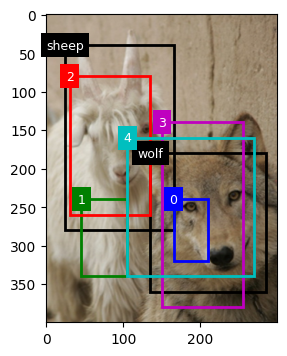

In [20]:
# 真实边界框和标签，第一个列表示标签
ground_truth = tf.constant([[0, 0.45, 0.45, 0.95, 0.90],
                            [1, 0.08, 0.10, 0.55, 0.70]])
# 随机定义 5 个锚框
anchors = tf.constant([[0.55, 0.60, 0.70, 0.80],
                       [0.15, 0.60, 0.35, 0.85],
                       [0.10, 0.20, 0.45, 0.65],
                       [0.50, 0.35, 0.85, 0.95],
                       [0.35, 0.40, 0.90, 0.85]])
# 绘制边界框和锚框
fig = plt.figure(figsize=(3, 4))
plt.imshow(img)
ch6.show_bboxes(fig.axes[0], ground_truth[:, 1:] * bbox_scale, labels=['wolf', 'sheep'], colors='k')
ch6.show_bboxes(fig.axes[0], anchors * bbox_scale, ['0', '1', '2', '3', '4'])

我们来为锚框分配真实边界框，并**生成锚框的标签**，返回的结果 `anchor_labels` 包含三个元素：

In [21]:
# 给真实边界框标签添加一个批量维度
anchor_labels = ch6.multibox_target(anchors, tf.expand_dims(ground_truth, axis=0))

第三个元素 `anchor_labels[2]` 是输入锚框对应的类别，其中：
* `class = 0` 表示**该锚框应该视作背景**
* **其他所有类别的标签都递增 1**，因此 `wolf` 对应 `class = 1`，`sheep` 对应 `class = 2`
* 锚框 $A_1,A_2$ 因为**只框选了非常小的局部**，无法识别目标整体，因此被视为背景，$A_3$ 对应 `sheep`，$A_4,A_5$ 对应 `wolf`

In [22]:
anchor_labels[2]

<tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[0, 0, 2, 1, 1]], dtype=int32)>

第二个元素 `anchor_labels[1]` 是掩码 `mask`，形状为 `(batch_size, 4*num_anchor)`，**掩码中的元素与每个锚框的 4 个偏移量一一对应**
* 由于我们不关心背景的检测，**负类的偏移量不应该影响损失函数的计算**，通过乘以掩码 `mask`，可以**在计算损失函数时过滤掉背景带来的损失**

In [23]:
anchor_labels[1]

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]], dtype=float32)>

第一个元素 `anchor_labels[0]` 即**每个锚框标记的四个偏移量** `offset`，形状与 `mask` 相同，即 `(batch_size, 4*num_anchor)`，其中**负类锚框的偏移量被设置为 0**

In [24]:
anchor_labels[0]

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
         1.1428570e+00, -5.5555505e-01,  1.4740015e+00,  1.4384137e+00,
         7.1428496e-01,  4.1666624e-01,  1.7833779e+00, -1.4384041e+00,
         1.3636363e+00,  1.1111100e+00, -4.7654483e-01,  4.7683693e-06]],
      dtype=float32)>

### **6.1.3 使用 @tf.function 和 tf.map_fn 装饰器加速算子**

在上面有关**生成锚框** `generate_multi_bbox`，**将真实边界框分配给锚框** `assign_anchor_to_bbox` 和 **给锚框标记类别和偏移量** `multibox_target` 三个函数中
* 我们**重在介绍函数的计算逻辑**，只保证它们能运行出正确的结果，没有考虑函数的执行效率
* 在实践中，这些函数**每次会同时处理一个批量的多个样本**，每个图像样本可能会**处理几千个锚框**，此时**计算性能将变得非常重要**

我们随机生成 5000 个锚框，来测试上述函数的性能

In [25]:
# 随机生成锚框和真实边界框
import timeit
batch_size, num_anchors, num_gt_bbox = 64, 5000, 10
anchors = tf.concat([tf.random.uniform((num_anchors, 2), maxval=0.5), 
                     tf.random.uniform((num_anchors, 2), minval=0.5, maxval=1)], axis=1)
gt_bbox = tf.concat([tf.random.uniform((batch_size, num_gt_bbox, 2), maxval=0.5), 
                     tf.random.uniform((batch_size, num_gt_bbox, 2), minval=0.5, maxval=1)], axis=2)
gt_bbox = tf.concat([tf.zeros((batch_size, num_gt_bbox, 1)), gt_bbox], axis=2) # 添加第 1 列，表示类别
print('anchors 形状:', anchors.shape, '\ngt_bbox 形状:', gt_bbox.shape)

anchors 形状: (5000, 4) 
gt_bbox 形状: (64, 10, 5)


In [26]:
# 运行 10 次，计算时间
_ = ch6.multibox_target(anchors, gt_bbox) # 预热，避免影响计时
time_used = timeit.timeit(lambda: ch6.multibox_target(anchors, gt_bbox), number=10)
print('time used: %.2f sec' % time_used)

time used: 49.74 sec


**(1) @tf.function 装饰器**

在 Tensorflow 中，一种实现加速的方法，是在自己定义计算逻辑的**函数前加上** `@tf.function` **装饰器**
* 被 `@tf.function` 装饰的函数，其执行逻辑会被自动转换为**Tensorflow 计算图**
* 函数在**第一次被调用时**，会自动将所有的执行逻辑会被 Tensorflow 内部算子重写为计算图函数
* 之后**再次调用该函数时**，如果**匹配上了符合要求的签名模板**（`input_signature`），则计算**直接在计算图上高效完成**
* 具体有关 `@tf.function` 的技术介绍、说明文档和注意事项，可以参考：[使用 @tf.function 提升性能](https://tensorflow.google.cn/guide/function?hl=zh_cn)

在这里，为了**快速入手** `@tf.function` 以获得性能增益，我们说明几个**最重要的注意事项**：
* 在函数执行逻辑内，**所有的操作必须通过** `tensorflow` **中包含的算子来完成**
    * 例如想要获得张量 `X` 的形状，请使用 `tf.shape(X)`，而不要使用 `X.shape`
* **尽可能减少 Python 数据类型的使用**，所有变量都使用 `tf.Tensor`
    * 例如函数中所需要的常数，也可以全部用 `tf.constant` 进行包装
* 有关**通过索引访问变量，或者根据索引修改变量时**：
    * 使用 `tf.gather` 根据索引获取变量，使用 `tf.tensor_scatter_nd_update` 根据索引修改变量
    * 如果要**修改连续的行 / 列**，可以直接利用 `tf.concat` 技巧，例如：
        ```python
        X = tf.zeros((3, 5))

        # 将 2-4 列的值变为 1
        X = tf.concat([X[:, :2], tf.ones((3, 3)), X[:, -1:]], axis=1)
        print(X)

        <tf.Tensor: shape=(3, 6), dtype=float32, numpy=
        array([[0., 0., 1., 1., 1., 0.],
               [0., 0., 1., 1., 1., 0.],
               [0., 0., 1., 1., 1., 0.]], dtype=float32)>
        ```
* **张量间的数值运算必须保证数据类型相同**，因此可能需要 `tf.cast` 做频繁的数据类型转换
* 在使用 `tf.reshape()` 改变张量形状时，**必须指明目标形状**，而**不能使用包含** `-1` 的**自动推断**
    ```python
    X = tf.range(16)
    # 使用 -1 自动推断该维度，在一般的语句中可行
    # 但在 @tf.function 中不可行
    X = tf.reshape(X, (-1, 4)) 
    ```
* `input_signature` 用于**指明函数输入的签名（限定输入的数据格式，包括形状和数据类型）**
    * 这不是使用 `@tf.function` 所必需的，但为了增强可读性，养成良好习惯，建议使用 `input_signature`

下面演示使用 `@tf.function` 装饰器修改后的函数 `generate_multi_bbox` 和 `assign_anchor_to_bbox`，为了加以区分，它们被重新命名为 `generate_multi_bbox_tf` 和 `assign_anchor_to_bbox_tf`

以下两个函数也已经写入了 `./source/code/ch6.py`

In [27]:
@tf.function(input_signature=[tf.TensorSpec(shape=(None, None, None, None), dtype=tf.float32),
                              tf.TensorSpec(shape=(None,), dtype=tf.float32),
                              tf.TensorSpec(shape=(None,), dtype=tf.float32)])
def generate_multi_bbox_tf(img, sizes, ratios):
    """
    ### 生成以每个像素为中心的锚框

    Parameters
    ----------
    img : tf.Tensor
        输入图像，形状为 (N, h, w, C)\n
        N 是图像的数量，C 是通道数，h 和 w 是图像的高和宽
    sizes : list
        锚框缩放比
    ratios : list
        锚框宽高比
    """
    height, width = tf.shape(img)[1], tf.shape(img)[2] # 图像的高和宽
    num_sizes, num_ratios = tf.shape(sizes)[0], tf.shape(ratios)[0] # 锚框缩放比和宽高比的数量
    boxes_per_pixel = num_sizes + num_ratios - 1 # 每个像素的锚框数量

    # 为了将锚框的中心放在像素的中心，需要设置偏移量 0.5
    # 因为每个像素都是 1x1 的小正方形，偏移 0.5 是小正方形中心
    offset_h, offset_w = 0.5, 0.5
    steps_h, steps_w = 1.0 / tf.cast(height,dtype=tf.float32), 1.0 / tf.cast(width,dtype=tf.float32) # 高度和宽度移动的步长

    # 生成锚框的中心坐标
    # 高度中心，(0.5/height, 1.5/height, ..., (height-0.5)/height)
    center_h = (tf.range(height, dtype=tf.float32) + offset_h) * steps_h
    # 宽度中心，(0.5/width, 1.5/width, ..., (width-0.5)/width)
    center_w = (tf.range(width, dtype=tf.float32) + offset_w) * steps_w
    # 生成网格，shift_y 和 shift_x 形状都是 (height, width)
    # indexij='ij' 表示生成的网格以 center_h 为行，center_w 为列
    shift_y, shift_x = tf.meshgrid(center_h, center_w, indexing='ij') 
    shift_y, shift_x = tf.reshape(shift_y, [height*width, ]), tf.reshape(shift_x, [height*width, ]) # 拉直为向量

    # 生成锚框的高度和宽度
    # 之后就可以和中心坐标一起组合成锚框的对角坐标
    # h = s/sqrt(r), w = s*sqrt(r)
    w = tf.concat((sizes * tf.sqrt(ratios[0]), sizes[0] * tf.sqrt(ratios[1:])), axis=0) * tf.cast(height / width,dtype=tf.float32)
    h = tf.concat((sizes / tf.sqrt(ratios[0]), sizes[0] / tf.sqrt(ratios[1:])), axis=0)
    
    # 第一步 tf.stack 生成 (n + m - 1, 4) = (boxes_per_pixel, 4) 的张量
    # 第二步 tf.tile 先将 anchor_wh 重复为 (boxes_per_pixel*height*width, 4)
    # 最后除以 2，得到半高半宽
    anchor_wh = tf.stack((-w, -h, w, h), axis=1) # 形状：(boxes_per_pixel, 4)
    anchor_wh = tf.tile(anchor_wh, (height*width, 1)) / 2 # 形状：(boxes_per_pixel*height*width, 4)

    # 生成锚框
    xy = tf.stack((shift_x, shift_y, shift_x, shift_y), axis=1) # 形状：(height*width, 4)
    # 同样将中心坐标复制 boxes_per_pixel 次，准备与 anchor_wh 运算
    xy = tf.repeat(xy, boxes_per_pixel, axis=0) # 形状：(boxes_per_pixel*height*width, 4)
    
    # 将中心坐标与半高半宽相加，得到锚框的对角坐标
    anchor_box = xy + anchor_wh # 形状：(boxes_per_pixel*height*width, 4)
    return anchor_box

In [28]:
@tf.function(input_signature=(tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                              tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                              tf.TensorSpec(shape=(), dtype=tf.int32),
                              tf.TensorSpec(shape=(), dtype=tf.float32)))
def assign_anchor_to_bbox_tf(ground_truth, anchors, valid_len, IoU_threshold : float=0.5):
    """
    ### 将真实边界框分配给锚框

    Parameters
    ----------
    ground_truth : tf.Tensor
        真实边界框，形状为 (num_gt_boxes, 4)
    anchors : tf.Tensor
        锚框，形状为 (num_anchors, 4)
    valid_len : int
        有效长度，即真实边界框的数量，去除掉填充边界框，即类别为 -1 的边界框
    IoU_threshold : float, default = 0.5
        IoU 阈值，只有 IoU 大于 该阈值，锚框才会被分配
    """
    num_anchors, num_gt_boxes = tf.shape(anchors)[0], tf.shape(ground_truth)[0]

    # 计算 IoU
    IoU = ch6.box_IoU_tf(anchors, ground_truth) # 形状：(num_anchors, num_gt_boxes)
    # 通过有效长度填充 -1，这些真是边界框所在得列不会被分配
    IoU = tf.concat([IoU[:, :valid_len], 
                     tf.zeros((num_anchors, num_gt_boxes - valid_len),dtype=tf.float32) - 1], axis=1)

    # 标记每个锚框，分配到真实边界框的张量，默认值为 -1，即不分配
    anchors_bbox_map = tf.zeros((num_anchors,),dtype=tf.int32) - 1 # 形状：(num_anchors, )

    # 根据阈值，挑选出参与分配的锚框
    max_IoU, index = tf.reduce_max(IoU, axis=1), tf.argmax(IoU, axis=1, output_type=tf.int32) # 找到每一行的最大 IoU 及其索引
    anc_i = tf.reshape(tf.where(max_IoU >= IoU_threshold), (num_anchors, 1)) # 筛选超过阈值的锚框索引
    box_j = index[max_IoU >= IoU_threshold] # 去除超过阈值的锚框对应的边界框索引
    # 将分配的结果写入 map
    # 在后续流程中，只有这些锚框才会被分配
    # 这实际上完成了算法的第 4 步
    anchors_bbox_map = tf.tensor_scatter_nd_update(anchors_bbox_map, anc_i, box_j)

    # 用于填充分配后的行列，完成丢弃
    col_discard = tf.zeros((num_anchors,1),dtype=tf.float32) - 1 # tf.fill(num_anchors, -1.0)
    row_discard = tf.zeros((1,num_gt_boxes),dtype=tf.float32) - 1# tf.fill(num_gt_boxes, -1.0)
    
    for _ in range(num_gt_boxes):
        max_idx = tf.argmax(tf.reshape(IoU, (num_anchors*num_gt_boxes,)),output_type=tf.int32) # 选出最大 IoU 的索引
        box_idx = max_idx % num_gt_boxes
        anc_idx = max_idx // num_gt_boxes
        # anchors_bbox_map = tf.tensor_scatter_nd_update(anchors_bbox_map, [[anc_idx]], [box_idx])
        anchors_bbox_map = tf.concat([anchors_bbox_map[:anc_idx], [box_idx], anchors_bbox_map[anc_idx+1:]], axis=0)

        # # 将刚刚分配的锚框和边界框的 IoU 设置为 -1 完成丢弃
        # # 这样在下次迭代中，就不会再次分配
        IoU = tf.concat([IoU[:anc_idx, :], row_discard, IoU[anc_idx+1:, :]], axis=0)
        IoU = tf.concat([IoU[:, :box_idx], col_discard, IoU[:, box_idx+1:]], axis=1)
    
    return anchors_bbox_map

**(2) 使用 tf.map_fn 替代循环**

有时候，我们可能会遇到像 `multibox_target` 中的循环逻辑，**循环对批量中的每个样本进行，因此循环体内没有上下依存关系**，此时，可以使用 `tf.map_fn` 来替代循环，它可以**充分利用 GPU 的并行能力**

使用 `tf.map_fn` 非常简单，我们**将批量中每个样本的处理逻辑定义为一个函数**，例如 `task_single_batch`，然后按照 `tf.map_fn` 提供的参数接口直接调用即可
```python
Signature:
tf.map_fn(
    fn,
    elems,
    dtype=None,
    parallel_iterations=None,
    back_prop=True,
    swap_memory=False,
    infer_shape=True,
    name=None,
    fn_output_signature=None,
)
```

最重要的有三个参数：
* `fn`：要执行的计算逻辑，即单样本的处理函数 `task_single_batch`
* `elems`：要循环迭代的变量，变量的**第一个维度会被依次抽取，然后作为参数传入给** `fn`，**大部分场景下，第一个维度就是批量维度** `batch_size`
* `dtype` 或 `fn_output_signature`：指定输出的数据类型

其他参数的含义可以参考具体的函数文档

下面演示使用 `tf.map_fn` 修改后的函数 `multibox_target`，为了加以区分，它被重新命名为 `multibox_target_tf`
* 为了进一步加速，我们**同时使用了** `@tf.function` **装饰器**
* 由于给生成的锚框标定标签信息**不需要追踪梯度**，函数中使用了 `tf.nest.map_structure(tf.stop_gradient, ...)` 的形式包装了函数 `tf.map_fn`，以**阻止梯度追踪**
    * 别忘了在第一章介绍过，对模型参数**梯度的追踪是非常昂贵的**，在**不需要梯度的地方都可以声明** `tf.stop_gradient`

In [29]:
@tf.function(input_signature=(tf.TensorSpec(shape=(None, 4), dtype=tf.float32), 
                              tf.TensorSpec(shape=(None, None, 5), dtype=tf.float32)))
def multibox_target_tf(anchors, labels):
    """
    ### 给锚框标记类别和偏移量

    Parameters
    ----------
    anchors : tf.Tensor
        锚框，形状：(num_anchor, 4)
    labels
        真实边界框的信息，形状：(batch_size, num_gt_boxes, 5)
        5 个元素分别为：类别、左上角坐标、右下角坐标
    
    Returns
    -------
    batch_offset : tf.Tensor
        偏移量标签，形状：(batch_size, num_anchor*4)
    batch_mask : tf.Tensor
        锚框掩码，形状：(batch_size, num_anchor*4)
    batch_class_labels : tf.Tensor
        类别标签，形状：(batch_size, num_anchor)
    """
    def task_single_batch(anchors, label):
        num_anchor = tf.shape(anchors)[0]

        # 完成锚框和真实边界框的分配，形状：(num_anchor, )
        # 计算有效长度 valid_len，即真实边界框的数量，去除掉填充边界框，即类别为 -1 的边界框
        valid_len = tf.shape(tf.where(label[:, 0] >= 0))[0]
        anchors_bbox_map = ch6.assign_anchor_to_bbox_tf(label[:, 1:], anchors, valid_len)

        # 生成掩码，形状：(num_anchor, 4)
        # 成功分配的锚框对应的掩码值为 1，其余为 0
        # anchors_bbox_map >= 0 是分配了真实边界框的锚框
        bbox_mask = tf.repeat(tf.expand_dims(
            tf.cast(anchors_bbox_map >= 0, dtype=tf.float32), axis=-1), 4, axis=-1)
        
        # 将类别标签和分配的边界框坐标初始化为 0
        class_labels = tf.zeros((num_anchor, ), dtype=np.int32)
        assigned_bbox = tf.zeros((num_anchor, 4), dtype=np.float32)
        
        # 使用真实边界框标记锚框类别
        indices_true = tf.where(anchors_bbox_map >= 0) # 取出被分配的索引
        num_true = tf.shape(indices_true)[0] # 真实边界框的数量
        bbox_index = tf.reshape(tf.gather(anchors_bbox_map, indices_true), (num_true, )) # 分配得到的真实边界框索引
        # 将 indices_true 对应的 class_labels 和 assigned_bbox 更新为真实边界框的信息
        class_labels = tf.tensor_scatter_nd_update(
            class_labels, indices_true, tf.cast(tf.gather(label[:, 0], bbox_index),dtype=tf.int32) + 1)
        assigned_bbox = tf.tensor_scatter_nd_update(
            assigned_bbox, indices_true, tf.gather(label[:, 1:], bbox_index))

        # 偏移量计算，乘以 bbox_mask，将未分配的偏移量设置为 0
        offset = ch6.offset_boxes_tf(anchors, assigned_bbox) * bbox_mask # 形状：(num_anchor, 4)
        offset = tf.reshape(offset, (tf.shape(offset)[0]*4,))
        bbox_mask = tf.reshape(bbox_mask, (tf.shape(bbox_mask)[0]*4,))

        return offset, bbox_mask, class_labels

    # 调用 TensorFlow 的 map_fn 函数，对每个样本调用 task_single_batch 函数
    # 使用 tf.stop_gradient 阻止梯度的传播
    batch_offset, batch_mask, batch_class_labels = tf.nest.map_structure(
        tf.stop_gradient, 
        tf.map_fn(lambda x: task_single_batch(anchors, x), labels, 
                  fn_output_signature=(tf.float32, tf.float32, tf.int32),
                  parallel_iterations=labels.shape[0]))
    
    return batch_offset, batch_mask, batch_class_labels

现在，我们来测试改进后，函数的执行速度

In [30]:
# 运行 10 次，计算时间
_ = ch6.multibox_target_tf(anchors, gt_bbox) # 预热，避免影响计时
time_used = timeit.timeit(lambda: ch6.multibox_target_tf(anchors, gt_bbox), number=10)
print('time used: %.2f sec' % time_used)

time used: 10.55 sec


可以看到，**函数计算获得了明显的加速**，速度提升了大约 5 倍，加速程度和具体的函数逻辑有关系

最后，在完成 `@tf.function` 和 `tf.map_fn` 的转换后，别忘了**检查函数的输出结果和是否之前的保持一致**

In [31]:
offset_1, mask_1, cls_labels_1 = ch6.multibox_target(anchors, gt_bbox)
offset_2, mask_2, cls_labels_2 = ch6.multibox_target_tf(anchors, gt_bbox)

In [32]:
(offset_1 == offset_2).numpy().all()

True

----

### **练习**

1. 导入一张你喜欢的图像，最好包含多个目标，将它保存到 `./source/Chap6/` 文件夹下
    1. 尝试在图像中标注出你感兴趣的目标的边界框，并绘制出来
    2. 利用我们在本节定义的函数，在图像上生成一些锚框
    3. 构造一些锚框，然后给定真实边界框，调用函数为锚框分配真实边界框，得到每个锚框相关的标签信息（类别，偏移量）

2. 在模型训练时，锚框和真实边界框一般都使用相对位置表示，而不是用绝对位置，思考这样做的优势

----